# 协方差矩阵的估计
By Christopher van Hoecke and Max Margenot

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

长期以来，波动性一直是市场投资者的眼中钉。成功地度量波动率将允许对收益进行更精确的建模，并且更稳定的投资将带来更大的收益，但是准确地预测波动率是一个困难的问题。 

## 衡量波动率

为了做出明智的决定，波动性需要具有前瞻性和预测性。不幸的是，当我们考虑到对未来的稳健性需求时，简单地计算单个资产回报率的历史标准偏差是不够的。当我们将问题扩大到需要预测许多资产的波动性时，就会变得更加困难。

要对投资组合的整体变化进行建模，不仅要考虑投资组合中每种资产的波动性，还要考虑每种资产的两两协方差，这一点很重要。两个或多个资产之间的关系提供了有价值的见解，并为降低整体投资组合的波动性提供了一条路径。具有低协方差的大量资产可以保证它们独立地减少或增加。独立资产对我们投资组合的波动性影响较小，因为它们给了我们真正的多样性，帮助我们避免了[头寸集中风险](https://www.quantopian.com/lectures/position-concentration-risk)。

## 协方差

在统计学和概率论中，协方差是两个随机变量联合变异性的量度。当随机变量表现出相似的行为时，它们之间的协方差往往很高。在数学上，我们把X关于Y的协方差表示为:

$$ COV(X, Y) = E[(X - E[X])(Y - E[Y])]$$

注意，如果我们取$X$自身的协方差，我们得到:

$$ COV(X, X) = E[(X - E[X])(X - E[X])] = E[(X - E[X])^2] = VAR(X) $$

我们可以用同样的方法用协方差来量化不同资产之间的相似性。如果两种资产有很高的协方差，它们的行为通常是相同的。协方差特别高的资产基本上可以互相替代。

协方差矩阵构成了现代投资组合理论(MPT)的基础。MPT侧重于为给定的风险水平最大化回报，使我们评估该风险的方法变得至关重要。我们使用协方差来量化资产的联合风险，形成我们如何看待整个投资组合的风险。关键在于，投资于具有高两两协方差的资产几乎不能提供多样化，因为它们的波动是如何紧密相关的。

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import covariance
import yfinance as yf

让我们取两个密切相关的变量，$X$和$Y$的协方差。假设$X$是一个随机抽取的集合，$Y = 5X + \epsilon$，其中$\epsilon$是一些额外的噪声。我们可以使用上面的公式计算协方差，从而更清楚地了解X美元相对于资产Y美元的演变情况。

In [2]:
# Generate random values of x
X = np.random.normal(size = 1000)
epsilon = np.random.normal(0, 3, size = len(X))
Y = 5*X + epsilon

product = (X - np.mean(X))*(Y - np.mean(Y))
expected_value = np.mean(product)

print('Value of the covariance between X and Y:', expected_value) 

Value of the covariance between X and Y: 5.078846293789456


我们也可以用一个函数来计算$X$和$Y$之间的协方差。

In [3]:
np.cov([X, Y])

array([[ 1.04364628,  5.08393022],
       [ 5.08393022, 33.35896726]])

这给出了$X$和$Y$之间的协方差矩阵。对角线是它们各自的方差，$(i, j)$是指以$i$和$j$为索引的资产之间的协方差。

In [4]:
print(np.var(X), np.var(Y)) 

1.0426026345216488 33.32560829319998


在这种情况下，我们只有两个资产，所以我们只有$(0,1)$和$(1,0)$。协方差矩阵是对称的，因为$COV(X, Y) = COV(Y, X)$，这就是为什么斜对角是互相镜像的。

我们可以直观地认为，当$X$改变时，$Y$改变了多少，反之亦然。因此，我们可以从$X$和$Y$之间关系的定义中预期协方差值约为5。

这里是$X$和$Y$之间的散点图，中间有一条最佳拟合的线。

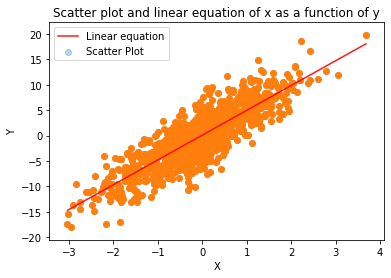

In [5]:
# scatter plot of X and y
from statsmodels import regression
import statsmodels.api as sm
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

linreg(X, Y)
plt.scatter(X, Y)
plt.title('Scatter plot and linear equation of x as a function of y')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Linear equation', 'Scatter Plot']);

在协方差、线性回归以及我们对$X$和$Y$之间关系的了解之间，我们可以很容易地评估我们的玩具变量之间的关系。对于真实数据，有两个主要的复杂因素。首先，我们有了更多的关系。第二，我们不知道它们之间的任何潜在关系。这些障碍说明了对协方差矩阵进行准确估计的好处。

## 协方差矩阵

随着我们所关心的资产数量的增加，描述它们之间关系的协方差矩阵的维数也随之增加。如果我们取$N$个资产之间的协方差，我们将得到一个$N \times N$的协方差矩阵。这允许我们一次有效地表达多个数组之间的关系。与简单的$2\times 2$的情况一样，第$i$个对角元素是第$i$个资产的方差，$(i, j)$和$(j, i)$是指资产$i$和资产$j$之间的协方差。我们用下面的符号来表示它:

$$ \Sigma = \left[\begin{matrix}
VAR(X_1) & COV(X_1, X_2) & \cdots & COV(X_1, X_N) \\
COV(X_2, X_0) & VAR(X_2) & \cdots & COV(X_2, X_N) \\
\vdots & \vdots & \ddots & \vdots \\
COV(X_N, X_1) & COV(X_N, X_2) & \cdots & VAR(X_N)
\end{matrix}\right] $$  

当试图找出许多资产的协方差时，很快就会发现为什么矩阵表示法更可取。

In [6]:
from pandas_datareader import data
# Four asset example of the covariance matrix.
start_date = '2016-01-01'
end_date = '2016-02-01'
returns = yf.download(['SBUX', 'AAPL', 'GS', 'GILD'],start_date,end_date)['Close'].pct_change()[1:]
returns.columns = ['SBUX', 'AAPL', 'GS', 'GILD']

print('Covariance matrix:') 
print(returns.cov()) 

[*********************100%***********************]  4 of 4 completed
Covariance matrix:
          SBUX      AAPL        GS      GILD
SBUX  0.000755  0.000244  0.000462  0.000330
AAPL  0.000244  0.000546  0.000155  0.000107
GS    0.000462  0.000155  0.000545  0.000362
GILD  0.000330  0.000107  0.000362  0.000502


## 为什么这一切如此重要?

我们衡量投资组合中资产的协方差，以确保我们对持有这些资产所涉及的风险有一个准确的认识。我们希望在这些资产中分配我们的资本，以使我们对每一项资产的风险敞口最小化，并消除对系统性风险的敞口。这是通过投资组合优化过程实现的。投资组合优化程序正是经过这个过程，根据每种资产的风险找到适当的权重。MPT的一个主要部分均值-方差优化就是这样做的。

在使用依赖协方差矩阵的方法时，估计协方差矩阵变得非常重要，因为我们无法知道所选资产背后的真实统计关系。这些评估的稳定性和准确性对于获得包含我们的风险和意图的稳定权重至关重要。

不幸的是，计算协方差矩阵估计最明显的方法，即样本协方差，是出了名的不稳定。如果我们对资产的时间观察少于资产的数量($T < N$)，那么这个估计就特别不可靠。极值对变化的反应更强烈，当协方差的极值跳来跳去时，我们的优化器会受到干扰，给我们不一致的权重。当我们试图对许多资产进行许多独立押注，以通过多样化来改善我们的风险敞口时，这是一个问题。即使我们拥有的时间元素比我们交易的资产更多，我们也会遇到问题，因为时间成分可能跨越多个政体，给我们的协方差矩阵仍然是不准确的。

在许多情况下，解决方案是使用一个稳健的公式的协方差矩阵。如果我们能够估计一个仍然能够捕获资产之间关系并且同时更稳定的协方差矩阵，那么我们就可以对我们的优化器的输出更有信心。我们处理这个问题的一个主要方法是使用某种形式的收缩估计值。

# 收缩估计

收缩的概念源于对稳定协方差矩阵的需要。我们“缩小”一个矩阵的基本方法是通过使样本协方差矩阵的极值更靠近中心来减少极值。实际上，我们取样本协方差的一个线性组合协方差矩阵一个代表中心的常数数组。

给定样本协方差矩阵$\textbf{S}$，均值方差$\mu$，收缩常数$\delta$，收缩后的估计协方差数学定义为:   

$$(1 - \delta)\textbf{S} + \delta\mu\textbf{I}$$  
 
我们限制$\delta$，使得$0 \leq \delta \leq 1$使其成为样本协方差与均值方差矩阵之间的加权平均值。$\delta$的最佳值已经被处理过几次了。出于我们的目的，我们将使用Ledoit和Wolf的配方.

## Ledoit-Wolf估计量。

在[他们的论文](http://ledoit.net/honey.pdf)中，Ledoit和Wolf提出了一个最优的$\delta$:

$$\hat\delta^* \max\{0, \min\{\frac{\hat\kappa}{T},1\}\}$$

$\hat\kappa$有一个超出这堂课范围的数学公式，但是你可以在论文中找到它的定义。

Ledoit-Wolf估计量是稳健的协方差估计，它使用这个最优的$\hat\delta^*$来缩小样本协方差矩阵。我们可以方便地直接从`scikit-learn`进行抽取从而实现它。

In [7]:
# Getting the return data of assets. 
start = '2016-01-01'
end = '2016-02-01'

symbols = ['AAPL', 'MSFT', 'BRK-A', 'GE', 'FDX', 'SBUX']
prices = yf.download(symbols,start,end)['Close']
prices.columns = ['AAPL', 'MSFT', 'BRK-A', 'GE', 'FDX', 'SBUX']
returns = prices.pct_change()[1:]

[*********************100%***********************]  6 of 6 completed


In [8]:
returns.head()

,AAPL,MSFT,BRK-A,GE,FDX,SBUX
Date,,,,,,
2016-01-04,0.000855,-0.007609,-0.037318,-0.014125,-0.012257,-0.029485
2016-01-05,-0.025059,0.003592,0.008506,0.000977,0.004562,0.006694
2016-01-06,-0.019570,0.002107,-0.026823,-0.015940,-0.018165,-0.008866
2016-01-07,-0.042205,-0.009295,-0.043901,-0.042314,-0.034783,-0.024772
2016-01-08,0.005288,-0.008590,0.000892,-0.017950,0.003067,-0.001058


这里我们计算样本内的Ledoit-Wolf估计量。

In [9]:
in_sample_lw = covariance.ledoit_wolf(returns)[0]
print(in_sample_lw) 

[[0.00067352 0.00014767 0.00028019 0.00020152 0.00041942 0.00026178]
 [0.00014767 0.0002102  0.00018814 0.00012788 0.00017193 0.00016211]
 [0.00028019 0.00018814 0.00051534 0.00023568 0.00036319 0.00029484]
 [0.00020152 0.00012788 0.00023568 0.00033827 0.00024079 0.00025787]
 [0.00041942 0.00017193 0.00036319 0.00024079 0.00052474 0.00025069]
 [0.00026178 0.00016211 0.00029484 0.00025787 0.00025069 0.00047197]]


### 计算误差

我们可以通过对两个矩阵的每个元素的绝对差来量化样本内和样本外估计值之间的差异。我们将其数学表示为:

$$ \frac{1}{n} \sum_{i=1}^{n} |a_i - b_i| $$

首先，我们计算样本外估计，然后进行比较。

In [10]:
oos_start = '2016-02-01'
oos_end = '2016-03-01'
oos_prices = yf.download(symbols,oos_start,oos_end)['Close']
oos_prices.columns =['AAPL', 'MSFT', 'BRK-A', 'GE', 'FDX', 'SBUX']
oos_returns = oos_prices.pct_change()[1:]
out_sample_lw = covariance.ledoit_wolf(oos_returns)[0]

[*********************100%***********************]  6 of 6 completed


In [11]:
lw_errors = sum(abs(np.subtract(in_sample_lw, out_sample_lw)))
print("Average Ledoit-Wolf error: ", np.mean(lw_errors)) 

Average Ledoit-Wolf error:  0.0008437856781925741


### 与样本矩阵相比

我们可以通过比较误差和样本协方差的误差来检查这种改进有多大.

In [12]:
sample_errors = sum(abs(np.subtract(returns.cov().values, oos_returns.cov().values)))
print( 'Average sample covariance error: ', np.mean(sample_errors))

Average sample covariance error:  0.0009489908826568544


In [13]:
print('Error improvement of LW over sample: {0:.2f}%'.format((np.mean(sample_errors/lw_errors)-1)*100)) 

Error improvement of LW over sample: 11.55%


我们可以看到，Ledoit-Wolf对样本协方差的改进是相当稳固的。这意味着降低了我们投资组合中的波动性和换手率，从而在使用缩小的协方差矩阵时增加了收益。

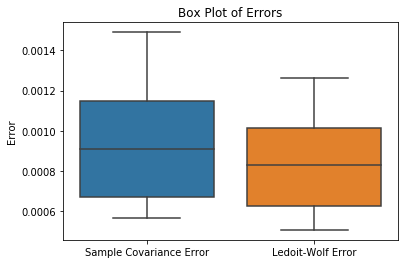

In [14]:
sns.boxplot(
    data = pd.DataFrame({
        'Sample Covariance Error': sample_errors,
        'Ledoit-Wolf Error': lw_errors
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');

### 添加更多的资产

现在我们在更长的一段时间内将其转化为更多的资产。让我们看看这些误差在几个月内是如何变化的。

In [ ]:
start_date = '2016-01-01'
end_date = '2017-06-01'

symbols = [
    'SPY', 'XLF', 'XLE', 'XLU','XLK', 'XLI', 'XLB', 'GE', 'GS', 'BRK-A', 'JPM', 'AAPL', 'MMM', 'BA',
    'CSCO','KO', 'DIS','DD', 'XOM', 'INTC', 'IBM', 'NKE', 'MSFT', 'PG', 'UTX', 'HD', 'MCD', 'CVX', 
    'AXP','JNJ', 'MRK', 'CAT', 'PFE', 'TRV', 'UNH', 'WMT', 'VZ', 'QQQ', 'BAC', 'F', 'C', 'CMCSA',
    'MS', 'ORCL', 'PEP', 'HON', 'GILD', 'LMT', 'UPS', 'HP', 'FDX', 'GD', 'SBUX'
]

prices = yf.download(symbols, start_date, end_date)['Close']
prices.columns = symbols
returns = prices.pct_change()[1:]

[**********************96%*********************  ]  51 of 53 completed

In [ ]:
dates = returns.resample('M').first().index

这里我们计算不同的协方差估计值。

In [ ]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)      

这里我们计算每个时间段的误差。

In [ ]:
lw_diffs = []
for pair in zip(lw_covs[:-1], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)
    
sample_diffs = []
for pair in zip(sample_covs[:-1], sample_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    sample_diffs.append(diff)

这里我们画出了随时间变化的误差!

In [ ]:
plt.plot(dates[2:], lw_diffs)
plt.plot(dates[2:], sample_diffs)
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors', 'Sample Covariance Errors']);

可以看出，Ledoit-Wolf的均值误差小于样本协方差矩阵的均值误差。这说明样本样本协方差矩阵的稳健性较差。这个例子只使用了50个资产，但是随着我们添加更多的资产，随着资产的数量超过观察值的数量，Ledoit-Wolf估计量可能会表现得更好。